<a href="https://colab.research.google.com/github/vineetsalar88/CompilerDesign/blob/master/31Dec25CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
# 1️⃣ Load CSV
# -------------------------------
csv_path = "/content/drive/MyDrive/ResearchData/AnnotatedDataset28Dec25/labelsWithPaths.csv"
image_folder = "/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images"   # folder containing your image files

df = pd.read_csv(csv_path)

# Add full image paths
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(image_folder, x))
pd.set_option('display.max_colwidth', None)
print(df['image_path'].head(10))





0    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/001.jpg
1    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/002.jpg
2    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/003.jpg
3    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/004.jpg
4    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/005.jpg
5    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/006.jpg
6    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/007.jpg
7    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/008.jpg
8    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/009.jpg
9    /content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images/010.jpg
Name: image_path, dtype: object


In [3]:
from PIL import Image
import os

broken_images = []

for path in df['image_path']:
    try:
        img = Image.open(path)
        img.verify()  # verify doesn't load the whole image, just checks integrity
    except Exception as e:
        broken_images.append((path, str(e)))

print(f"Found {len(broken_images)} broken images.")
for b in broken_images[:10]:
    print(b)


Found 0 broken images.


In [3]:
df.dropna(subset=['label'], inplace=True)
train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

In [6]:
from PIL import Image
#Create ImageDataGenerators -------------------------------
img_size = (128, 128)
batch_size = 32
df["label"] = df["label"].astype(str)
# Filter out rows with invalid image paths
train_df = train_df[train_df['image_path'].apply(lambda x: os.path.exists(x))]
val_df = val_df[val_df['image_path'].apply(lambda x: os.path.exists(x))]

# Add a robust check for image loading and resizing issues
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize(img_size) # Try resizing to trigger potential errors
        img.verify()
        return True
    except Exception as e:
        print(f"Could not load or process image {image_path}: {e}")
        return False

# Filter dataframes based on image loadability
train_df_cleaned = train_df[train_df['image_path'].apply(is_image_loadable)]
val_df_cleaned = val_df[val_df['image_path'].apply(is_image_loadable)]

print(f"Original train_df size: {len(train_df)}, Cleaned train_df size: {len(train_df_cleaned)}")
print(f"Original val_df size: {len(val_df)}, Cleaned val_df size: {len(val_df_cleaned)}")

# Convert the 'label' column to string type
train_df_cleaned['label'] = train_df_cleaned['label'].astype(str)
val_df_cleaned['label'] = val_df_cleaned['label'].astype(str)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df_cleaned,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Original train_df size: 437, Cleaned train_df size: 437
Original val_df size: 188, Cleaned val_df size: 188
Found 437 validated image filenames belonging to 6 classes.
Found 188 validated image filenames belonging to 6 classes.


In [8]:
# Make sure to run the cell above this one (cell `0zqEiKczWeK6`) to define `img_size`, `train_gen`, and `val_gen` first.
# 4️⃣ Build CNN Model
# -------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.2541 - loss: 1.8207 - val_accuracy: 0.2766 - val_loss: 1.5366
Epoch 2/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.2734 - loss: 1.5885 - val_accuracy: 0.3085 - val_loss: 1.5581
Epoch 3/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.3251 - loss: 1.5504 - val_accuracy: 0.2766 - val_loss: 1.5285
Epoch 4/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.3020 - loss: 1.5655 - val_accuracy: 0.3085 - val_loss: 1.5240
Epoch 5/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.2772 - loss: 1.5699 - val_accuracy: 0.3511 - val_loss: 1.4568
Epoch 6/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.3334 - loss: 1.5134 - val_accuracy: 0.3191 - val_loss: 1.4940
Epoch 7/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.2948 - loss: 1.5434 - val_accuracy: 0.3457 - val_loss: 1.4544
Epoch 8/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.3345 - loss: 1.5430 - val_accuracy: 0.3564 - val_loss:

✅ Validation Accuracy: 42.02%


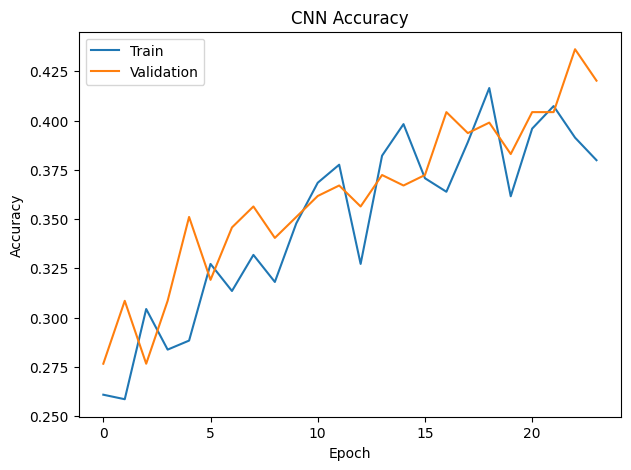

In [9]:
# Make sure to run the cell above this one to define and compile the model first.
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=24
)

# ============================================
# ❓ 9⏹  Evaluate and Save
# ============================================
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {val_acc*100:.2f}%")

model.save("cnn_multiclass_bbox_model.h5")

# ============================================
# ❓ ⟹⏹  Optional: Plot Accuracy
# ============================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()